# Likelihood evaluations for Palanque-Delabrouille et al. (2013)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
# temporal
import camb
# our own modules
import simplest_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import camb_cosmo
import fit_linP
import recons_cosmo
import compute_likelihood

### Specify suite of simulations to use, read P1D arxiv and setup simplest emulator

In [2]:
basedir='/Users/font/CosmoData/test_sim_emulator/test_medium/'
#basedir='../mini_sim_suite/'
p1d_label='mf_p1d'
skewers_label='Ns100_wM0.05'
emu=simplest_emulator.SimplestEmulator(basedir,p1d_label,skewers_label,verbose=False)

### Read P1D data from Palanque-Delabrouille et al. (2013)

In [3]:
basedir='../../p1d_data/data_files/PD2013/'
data=data_PD2013.P1D_PD2013(basedir=basedir,blind_data=False)
zs=data.z
Nz=len(zs)

### Setup nuisance models

In [4]:
mf_model=mean_flux_model.MeanFluxModel()
T_model=thermal_model.ThermalModel()

In [5]:
z=3.4
print('<F>(z=%.2f) = %f'%(z,mf_model.get_mean_flux(z)))
print('T_0(z=%.2f) = %f'%(z,T_model.get_T0(z)))
print('gamma(z=%.2f) = %f'%(z,T_model.get_gamma(z)))

<F>(z=3.40) = 0.542428
T_0(z=3.40) = 10000.000000
gamma(z=3.40) = 1.456532


### Setup cosmological model

In [6]:
# specify cosmology
cosmo = camb_cosmo.get_cosmology(mnu=0.15, ns=0.965, omch2=0.12)
# print relevant information about the cosmology object
camb_cosmo.print_info(cosmo)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 1.6128E-03, T_CMB = 2.7255E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


In [7]:
# compute linear power parameters, around z_star and kp_kms
z_star=3.0
kp_kms=0.009
linP_model=fit_linP.LinearPowerModel(cosmo,z_star=z_star,k_units='kms',kp=kp_kms)
linP_model.get_params()

{'Delta2_star': 0.34359089153174016,
 'alpha_star': -0.21586983258446132,
 'f_star': 0.97514327990258953,
 'g_star': 0.968209492732573,
 'n_star': -2.300572652881717}

### Use fiducial cosmology to reconstruct input cosmology

In [8]:
# setup fiducial cosmology
cosmo_fid = camb_cosmo.get_cosmology()
# reconstruct cosmology using linear parameter model (at z_star, kp_kms)
rec_cosmo=recons_cosmo.ReconstructedCosmology(linP_model,cosmo_fid)
# compute linear power parameters at each redshift (in Mpc)
linP_Mpc_params=rec_cosmo.get_linP_Mpc_params(zs)

Note: redshifts have been re-sorted (earliest first)


### For each redshift, plot data vs model

2.2 model {'Delta2_p': 0.52940508668690001, 'n_p': -2.3007135087498813, 'alpha_p': -0.21576273788697528, 'f_p': 0.95899824656437238, 'mF': 0.80075859414516326, 'gamma': 1.5523173420452847, 'sigT_Mpc': 0.13071399425598651}
2.8 model {'Delta2_p': 0.42463796726199332, 'n_p': -2.3007135087498813, 'alpha_p': -0.2157627378869619, 'f_p': 0.97227822727415136, 'mF': 0.68128831772300569, 'gamma': 1.4998705770834098, 'sigT_Mpc': 0.12145041127572205}
3.4 model {'Delta2_p': 0.34761780307480111, 'n_p': -2.3007135087498805, 'alpha_p': -0.21576273788696995, 'f_p': 0.97944520219171294, 'mF': 0.54242806197447857, 'gamma': 1.4565317960122977, 'sigT_Mpc': 0.11361265770091636}
4.0 model {'Delta2_p': 0.29021917083794507, 'n_p': -2.3007135087498805, 'alpha_p': -0.21576273788697711, 'f_p': 0.98359699813521018, 'mF': 0.39911365088156847, 'gamma': 1.4197651254234163, 'sigT_Mpc': 0.106979709622334}


(0.005, 0.6)

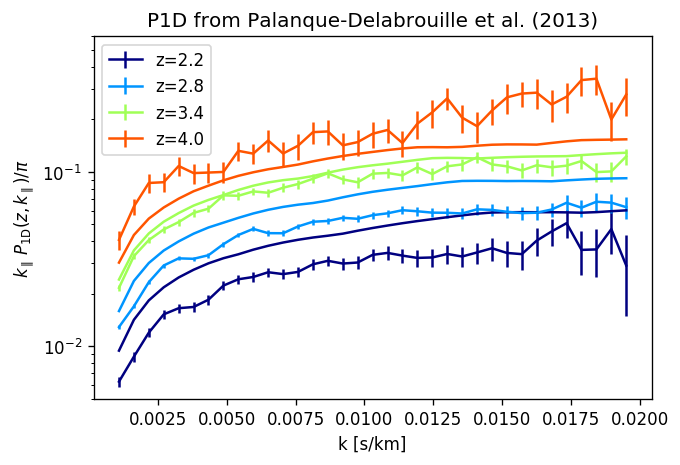

In [9]:
# plot only few redshifts for clarity
for iz in range(0,Nz,3):
    # acess data for this redshift
    z=zs[iz]
    p1d=data.get_Pk_iz(iz)
    cov=data.get_cov_iz(iz)
    # get emulator parameters for linear power, at this redshift (in Mpc)
    model=linP_Mpc_params[iz]
    # get emulator parameters for nuisance models, at this redshift
    model['mF']=mf_model.get_mean_flux(z)
    model['gamma']=T_model.get_gamma(z)
    T0=T_model.get_T0(z)
    sigT_kms=thermal_model.thermal_broadening_kms(T0)
    dkms_dMpc=rec_cosmo.reconstruct_Hubble(z)/(1+z)
    model['sigT_Mpc']=sigT_kms/dkms_dMpc
    print(z,'model',model)
    # emulate p1d
    emu_k_Mpc, emu_p1d_Mpc = emu.emulate_p1d(model)
    emu_k_kms = emu_k_Mpc / dkms_dMpc
    emu_P_kms = emu_p1d_Mpc * dkms_dMpc
    k_kms=data.k
    emu_p1d = np.interp(k_kms,emu_k_kms,emu_P_kms)
    # plot everything
    col = plt.cm.jet(iz/(Nz-1))
    plt.errorbar(k_kms,p1d*k_kms/np.pi,color=col,yerr=np.sqrt(np.diag(cov))*k_kms/np.pi,label='z=%.1f'%z)
    plt.plot(k_kms,emu_p1d*k_kms/np.pi,color=col)
plt.yscale('log')
plt.legend()
plt.title('P1D from Palanque-Delabrouille et al. (2013)')
plt.xlabel('k [s/km]')
plt.ylabel(r'$k_\parallel \, P_{\rm 1D}(z,k_\parallel) / \pi$')
plt.ylim(0.005,0.6)

In [14]:
total_chi2, chi2_z, nearest = compute_likelihood.get_chi2(data,cosmo_fid,emu,rec_cosmo,mf_model,T_model,linP_Mpc_params,extra_info=True,verbose=False)

### Plot chi2 vs mean optical depth parameter

In [11]:
# effective optical depth at z=3
tau_0 = np.linspace(0.2,0.6,20)
Ntau=len(tau_0)

In [12]:
chi2_tau=np.empty(Ntau)
for i in range(Ntau):
    mf_model=mean_flux_model.MeanFluxModel(z_tau=3.0,ln_tau_coeff=[3.2, np.log(tau_0[i])])
    chi2_tau[i] =compute_likelihood.get_chi2(data,cosmo_fid,emu,rec_cosmo,mf_model,T_model,linP_Mpc_params,extra_info=False)
    print(i,tau_0[i],np.exp(-tau_0[i]),chi2_tau[i])

0 0.2 0.818730753078 34856.9829493
1 0.221052631579 0.801674485786 30432.6617518
2 0.242105263158 0.784973544409 23526.0486796
3 0.263157894737 0.768620526594 21974.4043052
4 0.284210526316 0.752608184198 18155.7420516
5 0.305263157895 0.736929420078 16219.3021404
6 0.326315789474 0.721577284938 14469.3268838
7 0.347368421053 0.706544974258 13197.9480623
8 0.368421052632 0.691825825271 12924.017763
9 0.389473684211 0.677413314013 13331.5692138
10 0.410526315789 0.663301052433 14308.4316166
11 0.431578947368 0.649482785557 15754.7898618
12 0.452631578947 0.63595238872 16559.7767505
13 0.473684210526 0.622703864848 19341.3566139
14 0.494736842105 0.609731341802 21699.8695372
15 0.515789473684 0.597029069775 24196.0699844
16 0.536842105263 0.584591418744 28699.6481763
17 0.557894736842 0.572412875972 31941.2068252
18 0.578947368421 0.560488043569 34856.6262077
19 0.6 0.548811636094 41216.9934077


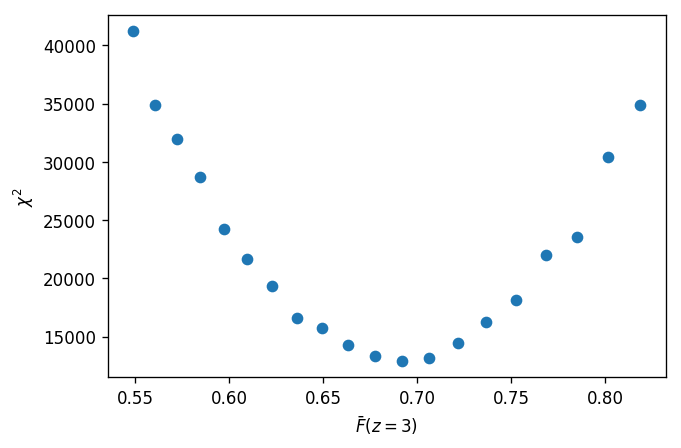

In [13]:
plt.plot(np.exp(-tau_0),chi2_tau,'o')
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')